# MOD_SIM_P_3 Workspace

### By Corey Cochran-Lepiz,
###   Shawn Albertson
   
Orbital Trajectories

### First step in any good code:import your libraries!


In [1]:
from math import *
from modsim import *
%matplotlib notebook


### Setup your units

In [2]:
m = UNITS.meter
km = UNITS.kilometer
s = UNITS.second
kg = UNITS.kilogram
N = kg * m/(s**2)
kN = kg * m/(s**2) * 1000
G = 6.67408 * (10**-11) * m**3 * kg**-1 * s**-2


### Setup conditions for bodies

In [3]:
set_duration = 200000000
num_steps = 1500

sun = Condition(x = 0 * m, #i'm using conditions instead of systems to reduce the am't of systems we have
             y = 0 * m,
             mass = 1.9891e30 * kg             
            )

mars = Condition(orbital_radius = 227.9e9 * m,
              radius = 3396200 * m,
              mass = .64171e24 * kg,
              orbital_speed = 24080 * m/s,
              duration = set_duration,
              ts_f = num_steps
                )

saturn = Condition(orbital_radius = 1.429e12 * m,
                mass = 5.683e26 * kg,
                orbital_speed = 9680 *m/s,
                radius= 58.232e6 * m,
                duration = set_duration,
                ts_f = num_steps                
                  )

titan = Condition(radius = 2575e3 *m,
               mass = 1.3455e23 * kg,
               orbital_speed = 5570 *m/s,
               orbital_radius = 1221865e3 * m,
               duration = set_duration,
               ts_f = num_steps
              )

rocket = Condition(orbital_radius = 100000 *m + mars.radius,
                dry_mass = 1433788 * kg,
                rho = 0.02 * kg/m**3, #needs function to update
                thrust = 22800000 * N,
                fuel_init = 1000000 * kg,
                duration = set_duration,
                ts_f = num_steps             
                  )

r_combo = Condition(r_orbital_radius = 100000 *m + mars.radius,
                r_dry_mass = 1433788 * kg,
                m_orbital_radius = 227.9e9 * m,
                m_radius = 3396200 * m,
                m_mass = .64171e24 * kg,
                m_orbital_speed = 24080 * m/s,
                duration = set_duration,
                ts_f = num_steps
)


###  Make_systems!!!

In [83]:
def make_system_planet(condition,theta): #in degrees
    """
    Using the condition given creates a system with the planet
    at theta with a velocity 90 degress from it allowing it to orbit 
    the origin in the counterclockwise direction.
    """
    unpack(condition)
    
    theta1 = np.deg2rad(theta*UNITS.degree) #transaltes from degress to radians
    x,y = pol2cart(theta1,orbital_radius)   #gets the x and y position given theta and orbital radius
    vx,vy = pol2cart(theta1+.5*pi*UNITS.radian,orbital_speed) #velocity to orbit
    print(vx,vy)
    init = State(x=x,y=y,vx=vx,vy=vy) #Staaaaate
    
    ts = linspace(1,duration,ts_f)
    
    return System(init=init,mass=mass,radius=radius,ts=ts)
    
def make_system_titan(condition,system,theta): #the system being that of Saturn
    """
    Does the same thing above but in reference to Saturn
    """
    unpack(condition)
    theta1 = np.deg2rad(theta*UNITS.degree)
    x,y = pol2cart(theta1,orbital_radius)
    
    x += system.init.x #in reference to sat
    y += system.init.y
    
    vx,vx = pol2cart(theta1+.5*pi*UNITS.radian,orbital_speed)
    
    init = State(x=x,y=y,vx=vx,vy=vy)
    
    return System(init=init,mass=mass,radius=radius)

def make_system_combo(condition,theta):
    
    unpack(condition)
    
    mars = Condition(orbital_radius = 227.9e9 * m,
              radius = 3396200 * m,
              mass = .64171e24 * kg,
              orbital_speed = 24080 * m/s,
              duration = set_duration,
              ts_f = num_steps
                )     
                    
    sys_mars = make_system_planet(mars,theta)
    
    rocket = Condition(orbital_radius = 100000 *m + mars.radius,
                dry_mass = 1433788 * kg,
                rho = 0.02 * kg/m**3, #needs function to update
                thrust = 22800000 * N,
                fuel_init = 1000000 * kg,
                duration = set_duration,
                ts_f = num_steps             
                  )
    sys_rocket = make_system_rocket(rocket,sys_mars,theta)
    
    mx,my,mvx,mvy = sys_mars.init
    rx,ry,rvx,rvy = sys_rocket.init
    
    init = State(rx=rx,ry=ry,rvx=rvx,rvy=rvy,mx=mx,my=my,mvx=mvx,mvy=mvy)
    
    ts = linspace(1,duration,ts_f)
    
    return System(init=init,m_mass=mars.mass,r_mass=rocket.dry_mass+fuel_init,ts=ts)

In [62]:
def make_system_rocket(condition,system,theta):#system of Mars
    """
    conditon of rocket
    system of mars
    theta of its position relative to mars
    
    """
    unpack(condition)
    
    #print(system.init.vx,system.init.vy)
    mvx = system.init.vx
    mvy = system.init.vy
    
    theta1 = np.deg2rad(theta*UNITS.degree)
    x,y = pol2cart(theta1,orbital_radius)
    
    xm = system.init.x
    ym = system.init.y
    
    x += xm #in reference to Mars
    y += ym
    print(x,y)
    vx,vy = pol2cart(theta1+.5*pi*UNITS.radian,orbital_velocity(Vector(x,y).dist(Vector(xm,ym))))
    
    vx = vx + mvx
    vy = vy + mvy
    
    ts = linspace(1,duration,ts_f)
    
    init = State(x=x,y=y,vx=vx,vy=vy)#,fuel=fuel_init)
    
    return System(init=init,mass=mass,radius=radius,dry_mass=dry_mass,ts=ts)

#sys_rocket = make_system_rocket(rocket,sys_mars,180)


### Gravity!!!

In [26]:
def calc_mgrav(vr,vm, mass_rocket): #calculate gravity in reference to Mars
    """
    Given the vectors of two objects in space, find the force of gravity acting upon them.
    Pass two vectors with the x and y positons of the rocket and body in question
    G is the gravitational constant
    vr is the position vector of the rocket
    vm is the position vector of mars
    height is just the distance between the center of the two objects
    returns force vector from the rocket towards the body 
    """
    height = vr.dist(vm)
    grav = G * mars.mass * mass_rocket / (height)**2
    #print(height,grav/mass_rocket)
    
    a = Vector(vm.x-vr.x,vm.y-vr.y) #Creates a vector from the rocket to the object
    x,y = pol2cart(a.angle,grav) #the vector has the angle, and with the force of grav we turn them to cartesian 
    
    f_grav = Vector(x,y) #The vector!
    return f_grav

def calc_satgrav(vr,vsat,mass_rocket): #calculate gravity in reference to Saturn
    height = vr.dist(vsat)
    grav = G * saturn.mass * mass_rocket / (height)**2

    a = Vector(vsat.x-vr.x,vsat.y-vr.y)
    x,y = pol2cart(a.angle,grav)
    
    f_grav = Vector(x,y)
    return f_grav

def calc_tgrav(vr,vt,mass_rocket): #calculate gravity in reference to Titan
    height = vr.dist(vt)
    grav = G * titan.mass * mass_rocket / (height)**2

    a = Vector(vt.x-vr.x,vt.y-vr.y)
    x,y = pol2cart(a.angle,grav)
    
    f_grav = Vector(x,y)
    return f_grav


def calc_sgrav(vr,mass):#calculate gravity in reference to the Sun
    height = vr.mag #hah
    grav = G * sun.mass * mass / (height)**2
    
    x,y = pol2cart(vr.angle+pi*UNITS.radians,grav) #added pi to face in the right direction
    
    f_grav = Vector(x,y)
    return f_grav

### Some other important functions and such...

In [8]:
thrust_magnitude = 934000 * N,
flow_rate = -273.6 * kg/s
mass_initial = 108000 * kg
g = (calc_mgrav(Vector(-mars.orbital_radius-(mars.radius+15000*m),0),Vector(-mars.orbital_radius,0*m),1)).mag#9.81 * m * s**-2
#print(g)
I = 307.4 * s #Merlin in vacuum from https://www.reddit.com/r/spacex/comments/3lsm0q/f9ft_vs_f9v11_fuel_mass_flow_rate_isp/

def calc_dv(burn_time):
    """ 
    Calculates a change in velocity, taking burn time of thrusters as input
    implies a constant thrust, defined above
    refers to STAGE TWO of Spacex Falcon 9, link to source above
    """
    new_mass = mass_initial + burn_time*s*flow_rate
    """
    Calculates change in mass of fuel over time 
    references flow rate from source
    """
    #print(saturn.radius)
    dv = g*I*log(mass_initial/new_mass)
    return dv

def calc_radii(dv):
    #dv *= m/s
    
    vp  =  mars.orbital_speed + dv
    
    
    """
    Takes the change in velocity from the previous function
    Adds change in velocity to speed of mars, gives us speed of rocket as it orbits around the sun
    Puts this velocity into a magic sauce equation to calculate the distance 
    from the sun to the perigee and apogee, labelled r1 and r2 respectively
    This is the goal but the unit's aren't working, rip
    
    So I added something to get the right units trusting that your equation works so it should be fine now - Corey
    """
    #print(vp)
    #print(G)
    #print(mars.radius)
    #print(sun.mass)
    #print
    
    r1 = mars.orbital_radius
    f = (G * sun.mass*r1 - (vp**2)*(r1**2)) / ((vp**2)*(r1)-2*G*sun.mass)
    i=abs(f)
    print(mars.orbital_speed)
    print(vp)
    print(i)
    
    r2 = 2*i+r1
    return r1, r2

def orbital_velocity(height): #in meters
    """
    passes a height in meters
    returns magnitude (speed) of orbital velocity at that height
    """
    #height *= m
    v = (G*mars.mass/height)**(1/2)
    return v
   
    
def slope_func(state,t,system):
    x, y, vx, vy = state
    unpack(system)
    
    v = Vector(vx,vy)
    
    a_thrust = accel_thrust(system,v,t)
    
    a_grav = calc
    
    a = a_grav + a_thrust
    
    return v.x, v.y, a.x, a.y

3411200.0 meter 3.6805765025990973 meter / second ** 2


# Workspace!!!

In [104]:
set_duration = 15000000
num_steps = 1500

mars = Condition(orbital_radius = 227.9e9 * m,
              radius = 3396200 * m,
              mass = .64171e24 * kg,
              orbital_speed = 24080 * m/s,
              duration = set_duration,
              ts_f = num_steps
                )

rocket = Condition(orbital_radius = 100000 *m + mars.radius,
                dry_mass = 1433788 * kg,
                rho = 0.02 * kg/m**3, #needs function to update
                thrust = 22800000 * N,
                fuel_init = 1000000 * kg,
                duration = set_duration,
                ts_f = num_steps             
                  )

r_combo = Condition(duration = set_duration,
                ts_f = num_steps
)

com = make_system_combo(r_combo,180)
run_odeint(com,combo_slope)

print(com.results.tail)

#sys_mars = make_system_planet(mars,180)
#run_odeint(sys_mars,m_slope)

#sys_rocket = make_system_rocket(rocket,sys_mars,180)
#run_odeint(sys_rocket,r_slope)

#print(sys_rocket.results.tail)


-4.42342423852024e-12 meter / second -24080.0 meter / second
-227903496200.0 meter 2.7910128713582096e-05 meter


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


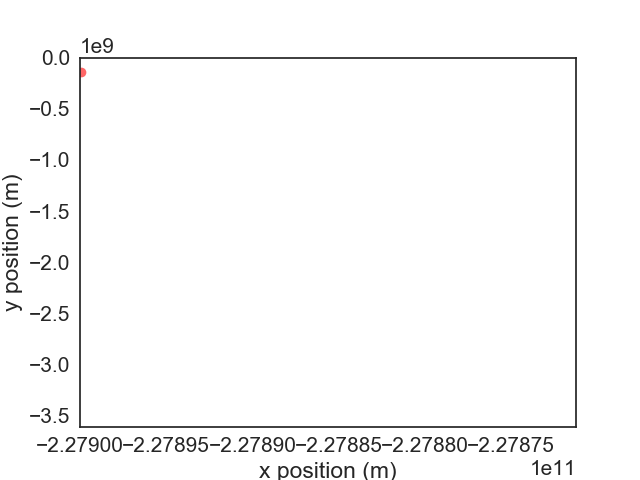

KeyboardInterrupt: 

In [93]:
newfig()
rad = mars.orbital_radius /m

decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[-rad-1000000, rad],
         ylim=[-rad-1000000, rad],
         legend=False)

rxs = com.results.rx
rys = com.results.ry
mxs = com.results.mx
mys = com.results.my

for rx,ry,mx,my in zip(rxs,rys,mxs,mys):
    plot(0,0,'yo',update=False)
    plot(mx, my, 'ro', update=True)
    #plot(rx,ry,'bo',update=True)
    sleep(0.01)

<IPython.core.display.Javascript object>


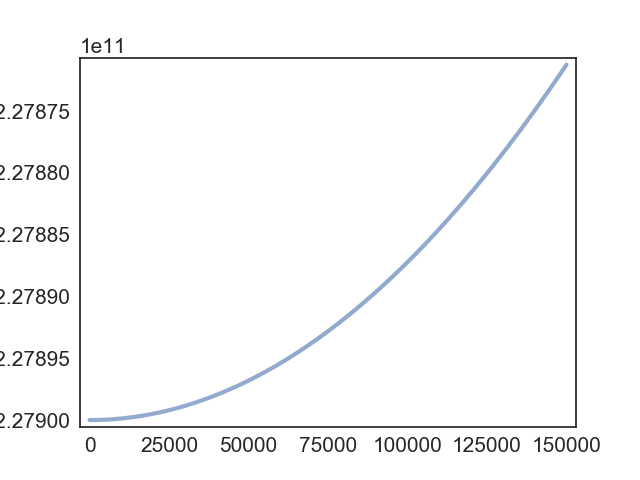

In [102]:
newfig()
#plot(rxs,label='x')
plot(mxs,label='y')


In [84]:
def combo_slope(state,t,system):
    
    rx,ry,rvx,rvy,mx,my,mvx,mvy = state
    
    unpack(system)
    #Make some vectors!
    m_pos = Vector(mx,my)
    m_vel = Vector(mvx,mvy)
    
    r_pos = Vector(rx,ry)
    r_vel = Vector(rvx,rvy)
    
    #Mars forces...
    m_f_grav = calc_sgrav(m_pos,1)
    m_a_grav = m_f_grav
    
    #Rocket forces...
    r_f_grav = calc_mgrav(r_pos,m_pos,mass)
    r_a_grav = r_f_grav/mass
    
    r_f_sgrav = calc_sgrav(r_pos,mass)
    r_a_sgrav = r_f_sgrav/mass
    
    a = r_a_grav + r_a_sgrav
    #return delta in each
    return rvx,rvy,a.x,a.y,mvx,mvy,m_a_grav.x,m_a_grav.y
    

def m_slope(state,t,system):
    
    x,y,vx,vy = state
    unpack(system)
    
    pos = Vector(x,y)
    vel = Vector(vx,vy)

    f_grav = calc_sgrav(pos,mass)
    a_grav = f_grav / mass
    
    #a_grav/m**2
    
    #print(vx)
    
    return vx,vy,a_grav.x,a_grav.y
    
def r_slope(state,t,system):
    
    x,y,vx,vy = state
    unpack(system)
    
    t = int(t) 
    
    pos = Vector(x,y)
    vel = Vector(vx,vy)
    
    mx = sys_mars.results.x.iloc[t] *m
    my = sys_mars.results.y.iloc[t] *m
    
    mpos = Vector(mx,my)
    
    f_grav = calc_mgrav(pos,mpos,mass)
    a_grav = f_grav/mass
    
    f_sgrav = calc_sgrav(pos,mass)
    a_sgrav = f_sgrav/mass
    
    a = a_grav + a_sgrav
    
    return vx,vy,a.x,a.y



In [10]:
def calc_mass_r(t): #What is this doing?
    rocket.fuel_init * -.18 * t
    return rocket.dry_mass + rocket.fuel_init
    
#calc_mass_r(30)

In [11]:
def accel_thrust(system,v,t): #NOT DONE
    """
    Returns an accel vector of thrust given a system, the objects velocity, and time.
    """
    unpack(system)
    
    
    return a_thrust

In [14]:
def run_phaseI()

SyntaxError: invalid syntax (<ipython-input-14-b0e9cc3c049e>, line 1)

# Unused Functions

In [ ]:
def height_from_mars(x,y): #Assuming that mars is at the origin
    """"
    Given an x and y returns the distance from the center
    of Mars assuming that Mars is at the origin.
    
    """"
    #[theta,rho] = cart2pol(x,y) #but it doens't like big numbers
    x /= m #strip the units
    y /= m
    rho = sqrt(x**2+y**2) * m #distance formula
    height = rho - (3396200*m)
    return height

def force_of_drag(v,h):
    """"
    Returns the force of drag given velocity of the object
    and it's distance away from the planet
    
    rho is the air density
    v is velocity of rocket
    c_d is drag coeffeciant of drag of the rocket but it's dependant on velocity
    """"
    C_d = drag(v)
    return -(1/2) * rho * v.mag * v * C_d * area

def rho(h): #math from NASA https://www.grc.nasa.gov/www/k-12/airplane/atmosmrm.html
    """"
    Returns the air density of Mars above the ground given the height
    """"
    if h < 7000: #two zones for density
        T = -31 - 0.000998 * h #temp
        P = .699*exp(-0.00009*h) #pressure
    else:
        T = -23.4 - 0.00222*h
        P = .699*exp(-0.00009*h)
    return P/(.1921*(T+273.1)) #return density